In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from collections import defaultdict
from sklearn.utils import resample

from collections import Counter
import itertools


import warnings

warnings.filterwarnings("ignore")


def create_classifiers(class_weight: str = "balanced"):
    classifiers = {
        "Logistic Regression": LogisticRegression(class_weight=class_weight),
        "SVM with RBF Kernel": SVC(kernel="rbf", class_weight=class_weight),
        "SVM with Linear Kernel": SVC(kernel="linear", class_weight=class_weight),
        "Random Forest": RandomForestClassifier(class_weight=class_weight),
        "Decision Tree": DecisionTreeClassifier(class_weight=class_weight),
        "k-NN": KNeighborsClassifier(),
    }

    param_grids = {
        "Logistic Regression": {"C": [0.001, 0.01, 0.1, 1, 10]},
        "SVM with RBF Kernel": {"C": [0.1, 1, 10], "gamma": [0.01, 0.1, 1]},
        "SVM with Linear Kernel": {"C": [0.1, 1, 10]},
        "Random Forest": {
            "n_estimators": [10, 50, 100],
            "max_depth": [None, 10, 20, 30],
        },
        "Decision Tree": {"max_depth": [None, 10, 20, 30]},
        "k-NN": {"n_neighbors": [3, 5, 7, 9]},
    }

    return classifiers, param_grids


def run_training_loop(
    X_train,
    y_train,
    task="a",
    class_weight: str = "balanced",
    verbose: bool = False,
    average="micro",
):
    # Define classifiers
    classifiers, param_grid = create_classifiers(class_weight=class_weight)

    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    # Metrics storage
    results = {
        name: {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1_score": [],
            "f1_macro": [],
        }
        for name in classifiers.keys()
    }
    n_classes = len(np.unique(y_train))

    aggregate_conf_matrix_train = {name: np.zeros((n_classes, n_classes)) for name in classifiers.keys()}

    best_params_models = {classifier: [] for classifier in classifiers.keys()}
    for train_index, val_index in skf.split(X_train, y_train):
        X_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # re init classifiers to prevent data leakage from previous fold
        classifiers, param_grid = create_classifiers(class_weight=class_weight)
        for name, clf in classifiers.items():
            search_clf = RandomizedSearchCV(clf, param_grid[name], scoring="f1_macro", cv=3, n_jobs=-1)

            # Train the classifier with the best hyperparameters

            search_clf.fit(X_cv, y_cv)

            best_params = search_clf.best_params_
            best_params_models[name].append(best_params)
            clf = search_clf.best_estimator_
            # Train the classifier
            clf.fit(X_cv, y_cv)

            # Predict
            y_pred = clf.predict(X_val)

            # Calculate metrics
            acc = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average=average)
            recall = recall_score(y_val, y_pred, average=average)
            f1 = f1_score(y_val, y_pred, average=average)
            f1_macro = f1_score(y_val, y_pred, average="macro")

            conf_matrix = confusion_matrix(y_val, y_pred, labels=np.unique(y_train))
            aggregate_conf_matrix_train[name] += conf_matrix

            # Store metrics
            results[name]["accuracy"].append(acc)
            results[name]["precision"].append(precision)
            results[name]["recall"].append(recall)
            results[name]["f1_score"].append(f1)
            results[name]["f1_macro"].append(f1_macro)

    return results, aggregate_conf_matrix_train, best_params_models

In [4]:
def print_pca_variance(X_train, n_components=2):
    pca = PCA(n_components=n_components)

    X_train = StandardScaler().fit_transform(X_train)
    X_train = pca.fit_transform(X_train)
    print(pca.explained_variance_ratio_)
    print("Sum of the two PCS", pca.explained_variance_ratio_.sum())


def get_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))


def standard_scale(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return pd.DataFrame(data_scaled, columns=data.columns, index=data.index)


def plot_boxplots(results, y):
    accuracy_data = []
    precision_data = []
    recall_data = []
    f1_data = []
    f1_macro = []

    class_names = sorted(set(y))

    for model, metrics in results.items():
        # Accuracy
        for acc in metrics["accuracy"]:
            accuracy_data.append([model, acc])
        for f1_mac in metrics["f1_macro"]:
            f1_macro.append([model, f1_mac])

        # Precision and Recall for each class
        for fold in range(len(metrics["precision"])):
            for class_idx, prec in enumerate(metrics["precision"][fold]):
                precision_data.append([model, class_names[class_idx], prec])
            for class_idx, rec in enumerate(metrics["recall"][fold]):
                recall_data.append([model, class_names[class_idx], rec])
            for class_idx, f1 in enumerate(metrics["f1_score"][fold]):
                f1_data.append([model, class_names[class_idx], f1])

    # Convert to DataFrame for easier plotting
    accuracy_df = pd.DataFrame(accuracy_data, columns=["Model", "Accuracy"])
    precision_df = pd.DataFrame(precision_data, columns=["Model", "Class", "Precision"])
    recall_df = pd.DataFrame(recall_data, columns=["Model", "Class", "Recall"])
    f1_df = pd.DataFrame(f1_data, columns=["Model", "Class", "F1 Score"])
    f1_macro_df = pd.DataFrame(f1_macro, columns=["Model", "F1 Score"])

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Boxplot for Accuracy
    sns.boxplot(x="Model", y="Accuracy", data=accuracy_df, ax=axs[0, 0])
    axs[0, 0].set_title("Accuracy Comparison")
    axs[0, 0].set_ylim(0, 1)
    labels = axs[0, 0].get_xticklabels()
    plt.setp(labels, rotation=45)

    # Boxplot for Precision
    sns.boxplot(x="Model", y="Precision", hue="Class", data=precision_df, ax=axs[0, 1])
    axs[0, 1].set_title("Precision Comparison by Class")
    axs[0, 1].set_ylim(0, 1)
    labels = axs[0, 1].get_xticklabels()
    plt.setp(labels, rotation=45)
    axs[0, 1].legend(title="Class", bbox_to_anchor=(1.04, 0.5), loc="center left")

    # Boxplot for Recall
    sns.boxplot(x="Model", y="Recall", hue="Class", data=recall_df, ax=axs[1, 0])
    axs[1, 0].set_title("Recall Comparison by Class")
    axs[1, 0].set_ylim(0, 1)
    labels = axs[1, 0].get_xticklabels()
    plt.setp(labels, rotation=45)
    axs[1, 0].legend(title="Class", bbox_to_anchor=(1.04, 0.5), loc="center left")

    # Boxplot for F1 Score
    sns.boxplot(x="Model", y="F1 Score", hue="Class", data=f1_df, ax=axs[1, 1])
    axs[1, 1].set_title("F1 Score Comparison by Class")
    axs[1, 1].set_ylim(0, 1)
    labels = axs[1, 1].get_xticklabels()
    plt.setp(labels, rotation=45)
    axs[1, 1].legend(title="Class", bbox_to_anchor=(1.04, 0.5), loc="center left")

    plt.tight_layout()
    plt.show()

    # plot f1 micro
    fig, axs = plt.subplots(1, 1, figsize=(15, 12))
    sns.boxplot(x="Model", y="F1 Score", data=f1_macro_df, ax=axs)
    axs.set_title("F1 Micro Comparison")
    axs.set_ylim(0, 1)
    labels = axs.get_xticklabels()
    plt.setp(labels, rotation=45)
    plt.tight_layout()
    plt.show()


def plot_pair_and_f1_micro(results):
    accuracies = {model: data["accuracy"] for model, data in results.items()}
    f1_score = {model: np.array(data["f1_macro"]) for model, data in results.items()}

    model_pairs = list(itertools.combinations(accuracies.keys(), 2))

    # Calculate differences between pairs of models
    differences = {}
    for model1, model2 in model_pairs:
        differences[f"{model1} vs {model2}"] = [acc1 - acc2 for acc1, acc2 in zip(accuracies[model1], accuracies[model2])]

    # Convert to a DataFrame for easier plotting
    accuracy_diff_df = pd.DataFrame(differences)

    differences_f1 = {}
    for model1, model2 in model_pairs:
        differences_f1[f"{model1} vs {model2}"] = [acc1 - acc2 for acc1, acc2 in zip(f1_score[model1], f1_score[model2])]

        # Convert to a DataFrame for easier plotting
    f1_diff_df = pd.DataFrame(differences_f1)

    # Convert F1 scores to a DataFrame for plotting
    f1_scores_df = pd.DataFrame(f1_score)

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 18))

    # # Plot accuracy differences
    # sns.boxplot(data=accuracy_diff_df, ax=axes[0])
    # axes[0].set_title('Boxplot of Accuracy Differences Between Models')
    # axes[0].set_ylabel('Difference in Accuracy')
    # axes[0].set_xticklabels(accuracy_diff_df.columns, rotation=90)

    # Plot F1 score differences
    sns.boxplot(data=f1_diff_df, ax=axes[0])
    axes[0].set_title("Boxplot of F1 Score Differences Between Models")
    axes[0].set_ylabel("Difference in F1 Score")
    axes[0].set_xticklabels(f1_diff_df.columns, rotation=90)

    # Plot F1 scores
    sns.boxplot(data=f1_scores_df, ax=axes[1])
    axes[1].set_title("Boxplot of F1 Scores for Each Model")
    axes[1].set_ylabel("F1 Score")
    axes[1].set_xticklabels(f1_scores_df.columns, rotation=90)

    plt.tight_layout()
    plt.show()


def plot_confusion_matricies(aggregate_conf_matrix_train: dict, aggregate_conf_matrix_test: dict, y):
    class_names = sorted(set(y))

    # Create a figure for train confusion matrices
    fig_train, axs_train = plt.subplots(3, 2, figsize=(15, 15))

    for i, (model, conf_matrix) in enumerate(aggregate_conf_matrix_train.items()):
        sns.heatmap(
            conf_matrix,
            annot=True,
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axs_train[i // 2, i % 2],
        )
        axs_train[i // 2, i % 2].set_title(f"Train Confusion Matrix - {model}")
        axs_train[i // 2, i % 2].set_xlabel("Predicted")
        axs_train[i // 2, i % 2].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

    # Create a figure for test confusion matrices
    fig_test, axs_test = plt.subplots(3, 2, figsize=(15, 15))

    for i, (model, conf_matrix) in enumerate(aggregate_conf_matrix_test.items()):
        sns.heatmap(
            conf_matrix,
            annot=True,
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axs_test[i // 2, i % 2],
        )
        axs_test[i // 2, i % 2].set_title(f"Test Confusion Matrix - {model}")
        axs_test[i // 2, i % 2].set_xlabel("Predicted")
        axs_test[i // 2, i % 2].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


def merge_dictionaries(dict1, dict2):
    merged_dict = {}
    # Iterate through each key in dict1
    for key in dict1.keys():
        if key in dict2:
            merged_dict[key] = {}
            for subkey in dict1[key]:
                # Check if the subkey exists in both dictionaries
                if subkey in dict2[key]:
                    # For accuracy, just append the list
                    if subkey == "accuracy" or subkey == "f1_micro":
                        merged_dict[key][subkey] = dict1[key][subkey] + dict2[key][subkey]
                    else:
                        # For arrays, append the lists of arrays
                        merged_dict[key][subkey] = dict1[key][subkey] + dict2[key][subkey]
                else:
                    # Handle the case where a subkey exists in dict1 but not in dict2
                    merged_dict[key][subkey] = dict1[key][subkey]
        else:
            # Handle the case where a key exists in dict1 but not in dict2
            merged_dict[key] = dict1[key]
    # Add any keys from dict2 that are not in dict1
    for key in dict2.keys():
        if key not in dict1:
            merged_dict[key] = dict2[key]
    return merged_dict


def run_train_multiple_testing(
    X_train,
    y_train,
    task="a",
    class_weight: str = "balanced",
    verbose: bool = False,
    average="micro",
    do_smote=False,
):
    if do_smote:
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X_train, y_train)
    results, aggregated_conf_matrix_train, best_params = run_training_loop(
        X_train,
        y_train,
        task=task,
        class_weight=class_weight,
        verbose=verbose,
        average=average,
    )
    return results, aggregated_conf_matrix_train, best_params

In [5]:
data = pd.read_csv("data/Fish3.txt", delimiter=" ")

X = data.drop(columns=["Species"])
y = data["Species"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = standard_scale(X_train)
X_test = standard_scale(X_test)

print_pca_variance(X_train, n_components=2)
get_distribution(y)

[0.64611998 0.25641265]
Sum of the two PCS 0.902532629937773


{'Bream': 542,
 'Perch': 374,
 'Pike': 236,
 'Roach': 212,
 'SilverBream': 242,
 'Smelt': 219,
 'Whitewish': 41}

## a)

In [ ]:
all_results_train = []
all_best_params = []
all_conf_matrix_train = {}

for _ in range(30):
    X_train_resampled, y_train_resampled = resample(X_train, y_train)
    (
        results_train_temp,
        conf_train,
        best_params,
    ) = run_train_multiple_testing(
        X_train_resampled,
        y_train_resampled,
        task="a",
        class_weight="balanced",
        average=None,
    )
    all_results_train.append(results_train_temp)
    all_best_params.append(best_params)
    for key, value in conf_train.items():
        if key in all_conf_matrix_train:
            all_conf_matrix_train[key] += value
        else:
            all_conf_matrix_train[key] = value


results_train = all_results_train[0]

for i in range(1, len(all_results_train)):
    results_train = merge_dictionaries(results_train, all_results_train[i])


for key, value in all_conf_matrix_train.items():
    all_conf_matrix_train[key] = value / value.sum(axis=1)[:, np.newaxis]

best_params = {}
for res in all_best_params:
    for key, value in res.items():
        if key in best_params:
            best_params[key] += value
        else:
            best_params[key] = value


params_list = best_params

final_params = {}
for model, params in params_list.items():
    # Convert each parameter combination into a string
    param_strings = [str(param) for param in params]

    # Use Counter to count the frequency of each parameter combination
    counter = Counter(param_strings)

    # Get the most common parameter combination
    most_common_param = counter.most_common(1)[0]

    print(f"Model: {model}, Most common parameter combination: {most_common_param}")

    final_params[model] = eval(most_common_param[0])


# Train the models with the best hyperparameters
test_conf_matrix = {}
classifiers = create_classifiers()[0]
classification_reports = {}
for model, clf in classifiers.items():
    clf.set_params(**final_params[model])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    print(f"Model: {model}, Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

    classification_reports[model] = classification_report(y_test, y_pred, output_dict=True)

    conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    test_conf_matrix[model] = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

In [25]:
# Create a list to store the aggregated results
aggregated_results = []

# Iterate over the classification reports
for model_name, report in classification_reports.items():
    # Extract the relevant metrics from the report
    accuracy = report["accuracy"]
    macro_avg_precision = report["macro avg"]["precision"]
    macro_avg_recall = report["macro avg"]["recall"]
    macro_avg_f1 = report["macro avg"]["f1-score"]
    weighted_avg_precision = report["weighted avg"]["precision"]
    weighted_avg_recall = report["weighted avg"]["recall"]
    weighted_avg_f1 = report["weighted avg"]["f1-score"]

    # Create a dictionary to store the aggregated results for this model
    model_results = {
        "Model": model_name,
        "Accuracy": accuracy,
        "Macro Avg Precision": macro_avg_precision,
        "Macro Avg Recall": macro_avg_recall,
        "Macro Avg F1": macro_avg_f1,
        "Weighted Avg Precision": weighted_avg_precision,
        "Weighted Avg Recall": weighted_avg_recall,
        "Weighted Avg F1": weighted_avg_f1,
    }

    # Append the model results to the aggregated results list
    aggregated_results.append(model_results)

# Create a Pandas DataFrame from the aggregated results
aggregated_df = pd.DataFrame(aggregated_results)

# Print the aggregated table
aggregated_df.to_csv("results.csv")

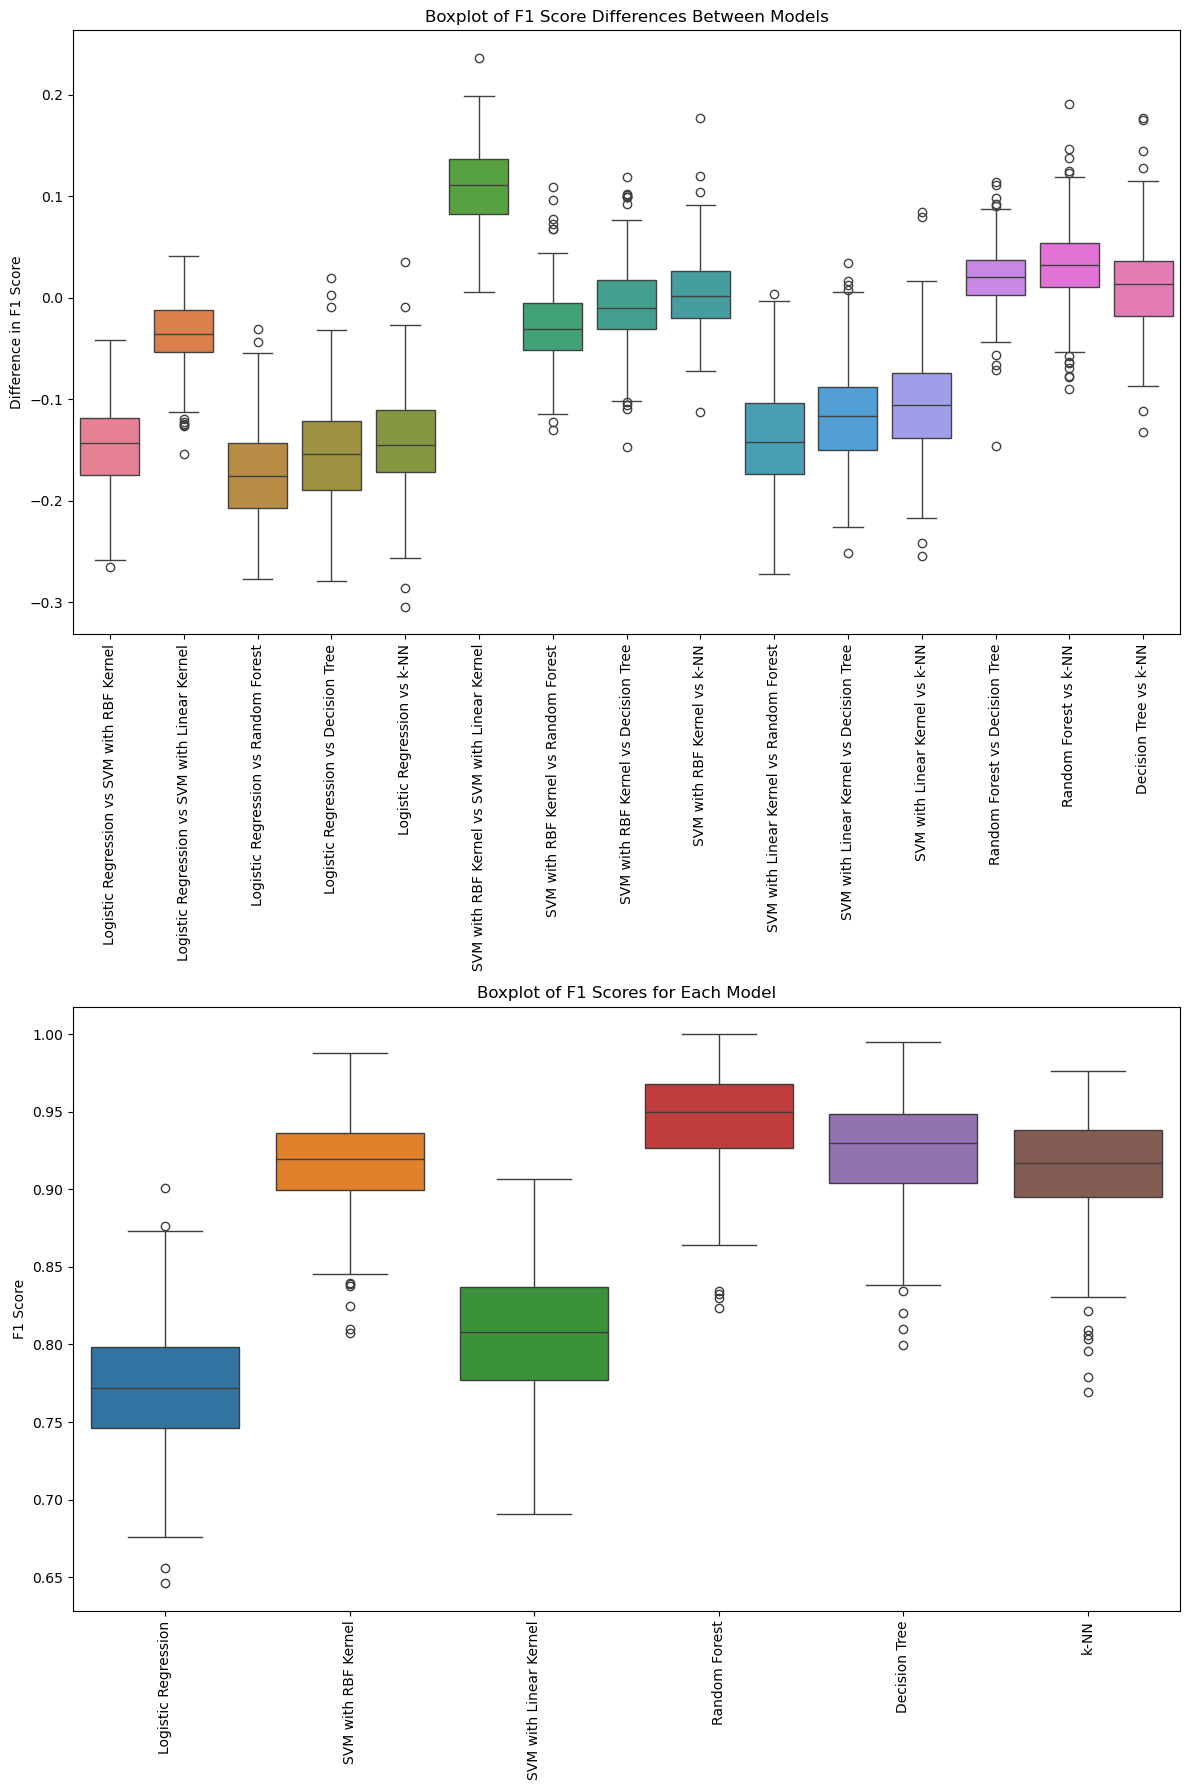

In [17]:
plot_pair_and_f1_micro(results_train)

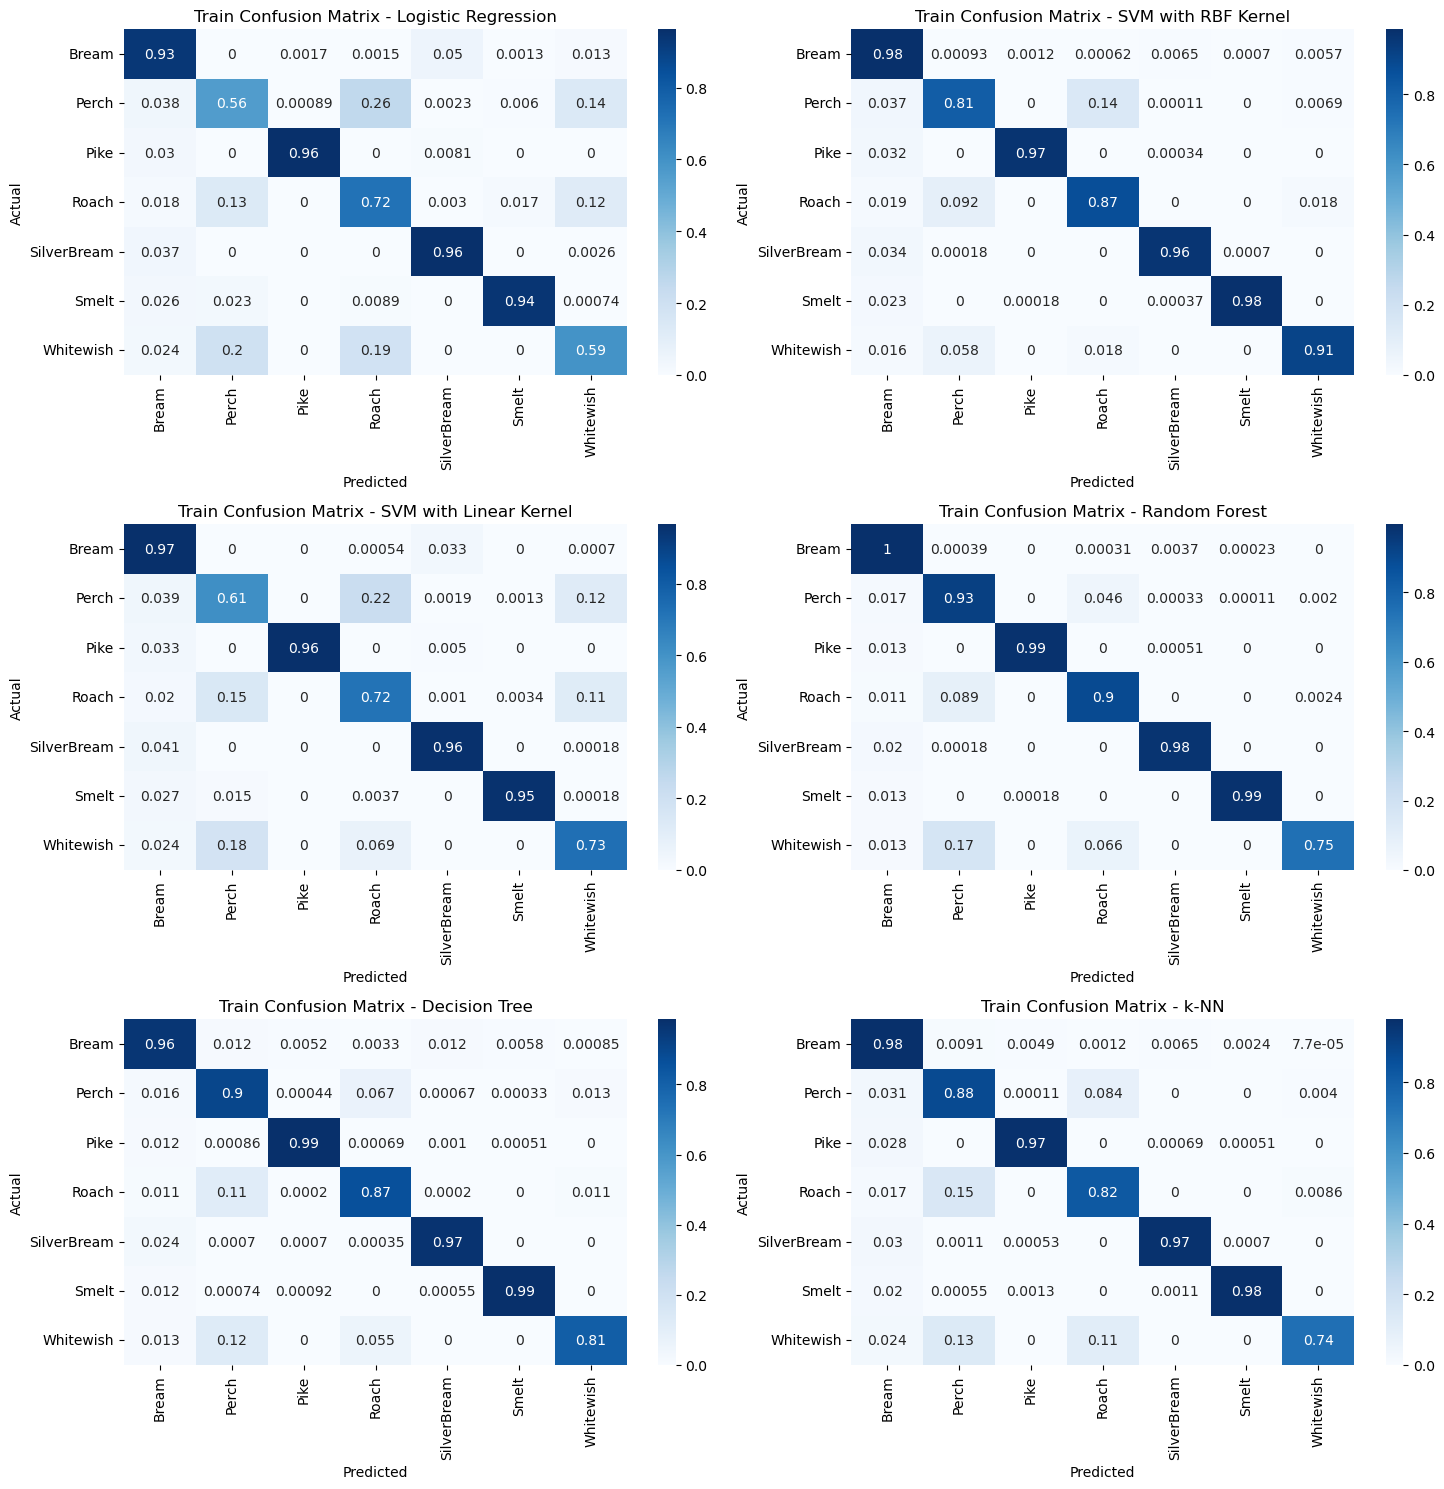

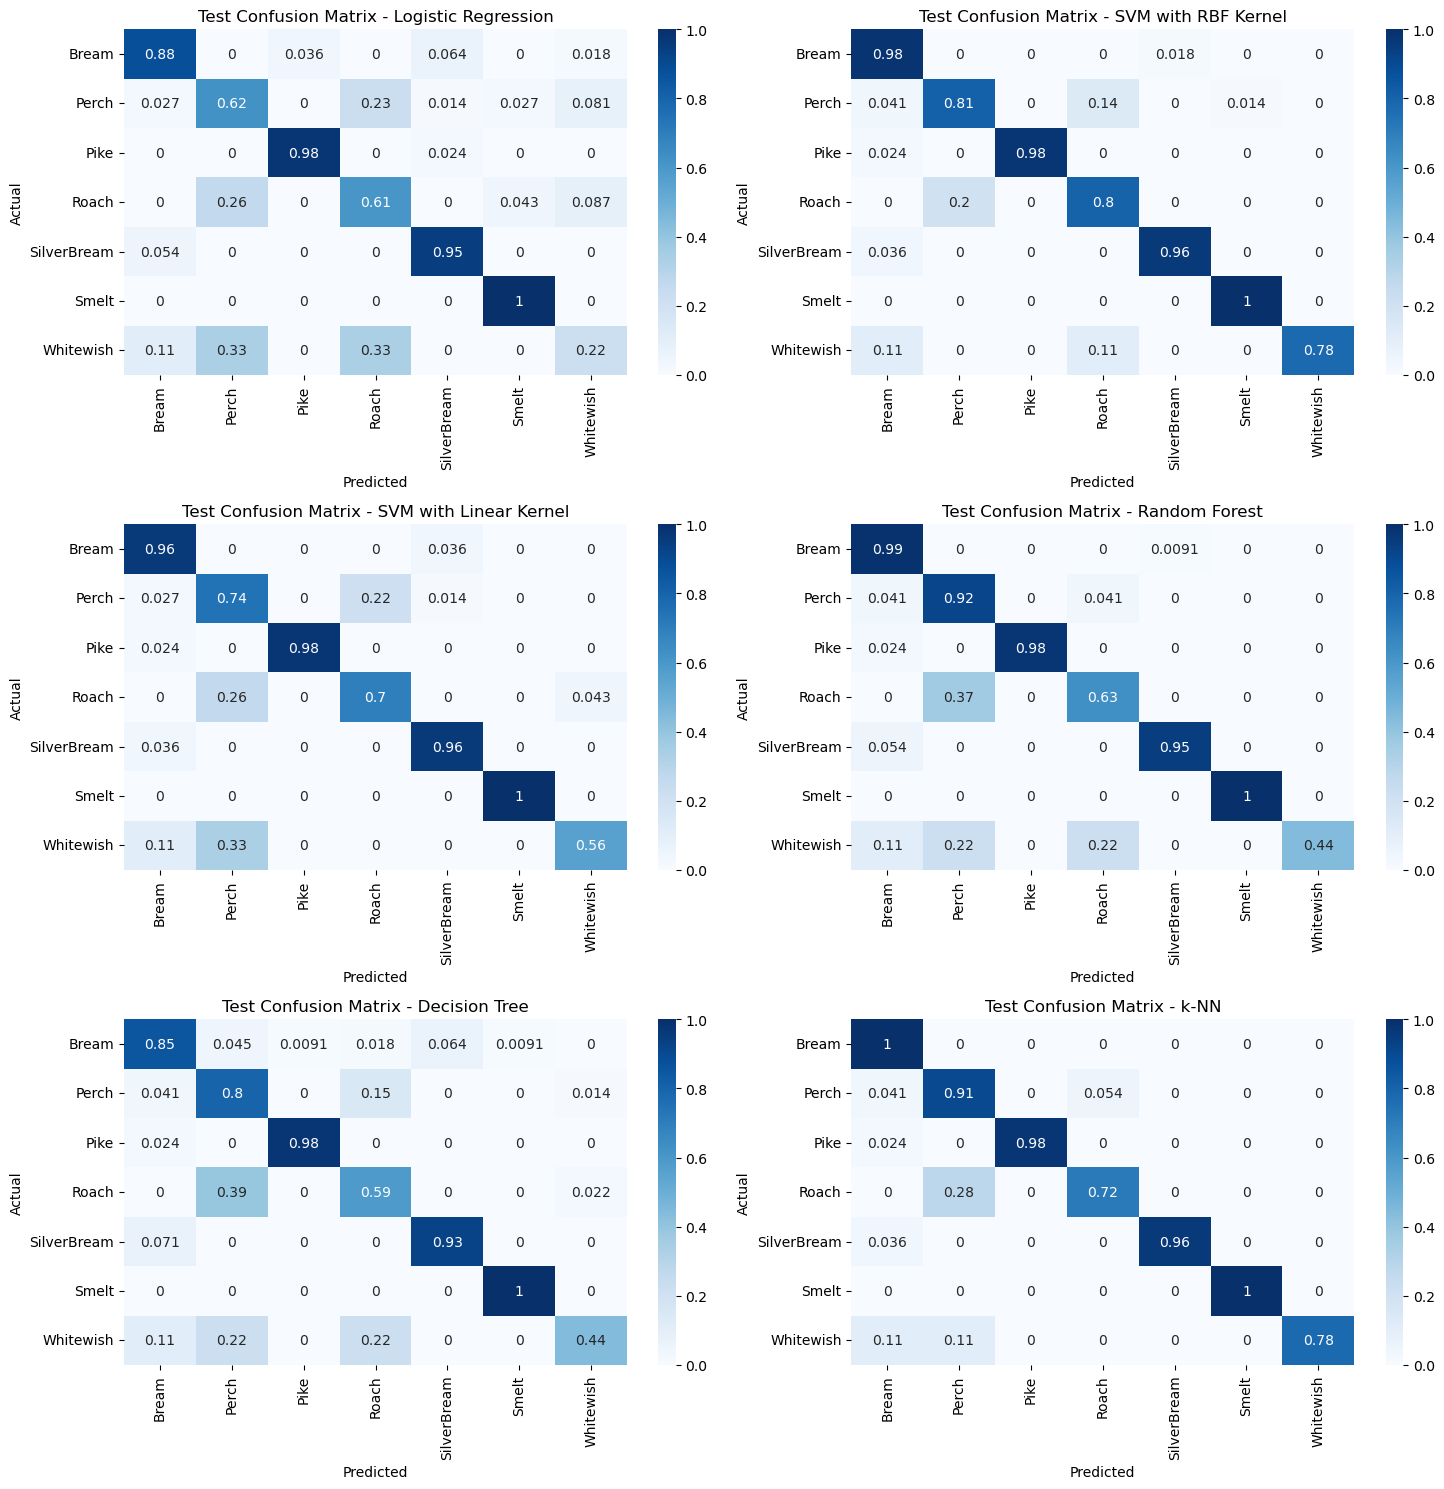

In [7]:
plot_confusion_matricies(all_conf_matrix_train, test_conf_matrix, y_test)

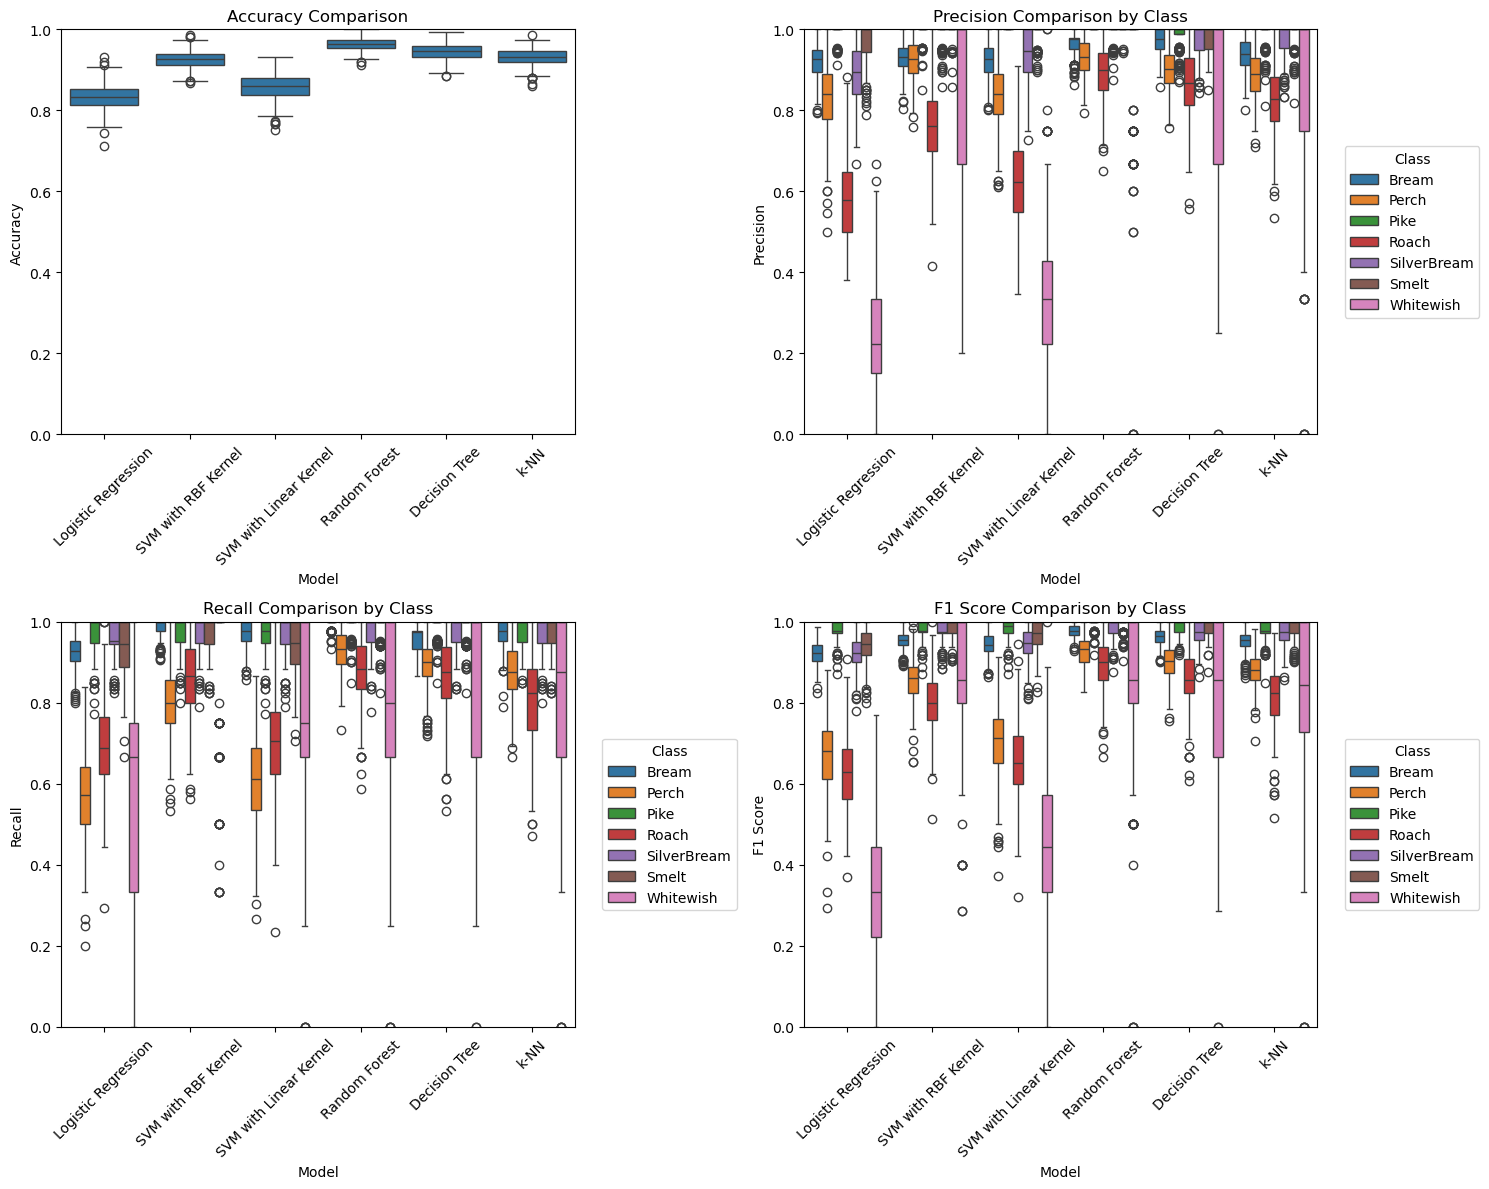

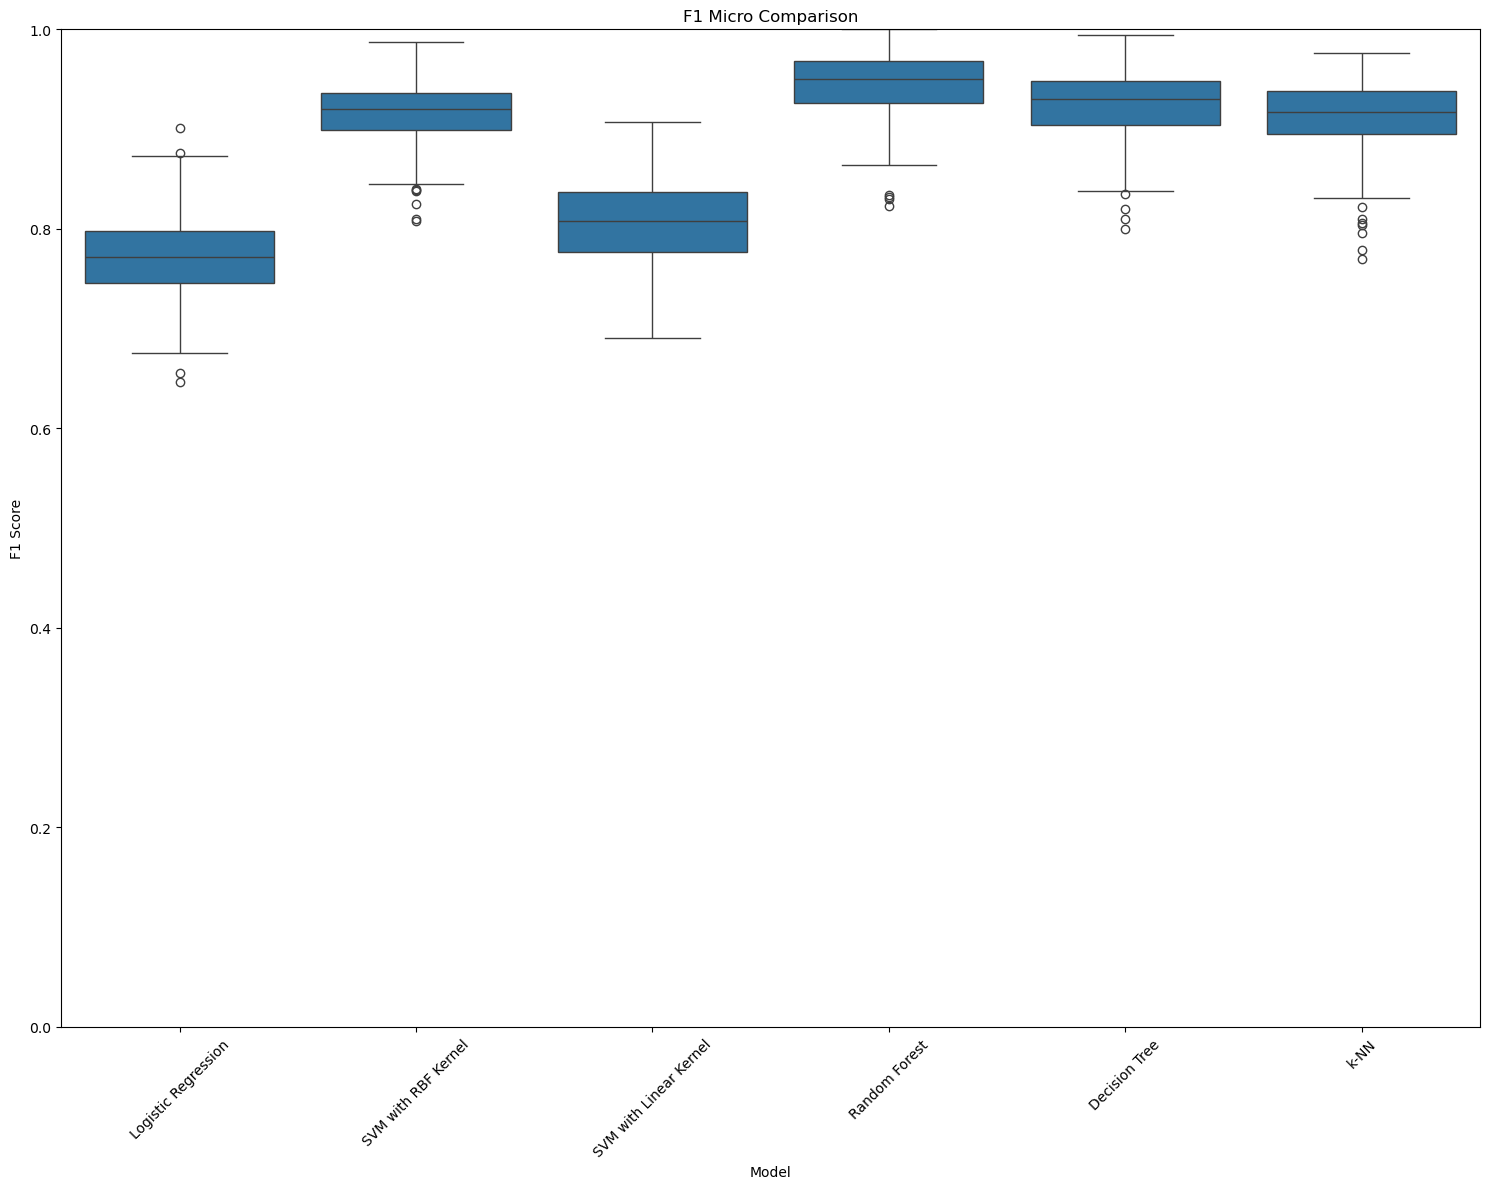

In [22]:
plot_boxplots(results_train, y)

## b

In [300]:

from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.base import clone



def create_classifiers(class_weight: str):
    classifiers = {
        "Logistic Regression": LogisticRegression(class_weight=class_weight),
        "SVM with RBF Kernel": SVC(kernel="rbf", class_weight=class_weight),
        "SVM with Linear Kernel": SVC(kernel="linear", class_weight=class_weight),
        "Random Forest": RandomForestClassifier(class_weight=class_weight),
        "Decision Tree": DecisionTreeClassifier(class_weight=class_weight),
        "k-NN": KNeighborsClassifier(n_neighbors=3),
    }
    return classifiers




def feature_selection_permutation_importance(X, y, clf, threshold = 0.1):
    temp_clf = clone(clf)
    temp_clf.fit(X, y)

    result = permutation_importance(temp_clf, X, y, n_repeats=10, random_state=0).importances_mean
    result = result / sum(result) #normalize 
    return result > threshold


def feature_selection_linear(X, y, clf):
    selector = RFECV(clf, step=1, cv=5, n_jobs=-1)
    selector.fit(X_train_resampled, y_train_resampled)
    return selector.support_


def feature_selection_tree_importances(X, y, clf):
    temp_clf = clone(clf)
    selector = SelectFromModel(temp_clf)
    selector.fit(X, y)



    return selector.get_support()  


def run_training_loop_features(X_train, y_train, class_weight="balanced", average="micro"):
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    classifiers = create_classifiers(class_weight)
    results = {name: {"accuracy": [], "precision": [], "recall": [], "f1_score": [], "f1_macro": [], "selected_features": [], "correctly_labeled": [], "mislabeled": []} for name in classifiers.keys()}

    for train_index, val_index in skf.split(X_train, y_train):
        X_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        classifiers = create_classifiers(class_weight)
        for name, clf in classifiers.items():

            # Select the appropriate feature selection method
            if name in ["k-NN", "SVM with RBF Kernel"]:
                feature_selector = feature_selection_permutation_importance
            elif name in ["SVM with Linear Kernel", "Logistic Regression"]:
                feature_selector = feature_selection_linear
            else:
                feature_selector = feature_selection_tree_importances

            selected_features = feature_selector(X_cv, y_cv, clf)

            X_cv_fs = X_cv.iloc[:, selected_features]
            X_val_fs = X_val.iloc[:, selected_features]

            clf.fit(X_cv_fs, y_cv)
            y_pred = clf.predict(X_val_fs)

            acc = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average=average)
            recall = recall_score(y_val, y_pred, average=average)
            f1 = f1_score(y_val, y_pred, average=average)
            f1_macro = f1_score(y_val, y_pred, average="macro")

            if name not in results:
                results[name] = {
                    "accuracy": [],
                    "precision": [],
                    "recall": [],
                    "f1_score": [],
                    "f1_macro": [],
                    "selected_features": [],
                    "correctly_labeled": [],
                    "mislabeled": [],
                }

            results[name]["accuracy"].append(acc)
            results[name]["precision"].append(precision)
            results[name]["recall"].append(recall)
            results[name]["f1_score"].append(f1)
            results[name]["f1_macro"].append(f1_macro)
            results[name]["selected_features"].append(selected_features)

            correct_mask = y_val == y_pred
            num_correctly_labeled = correct_mask.sum()
            num_mislabeled = (~correct_mask).sum()

            results[name]["correctly_labeled"].append(num_correctly_labeled)
            results[name]["mislabeled"].append(num_mislabeled)
            
    return results


def run_class_feature_selection(X_train, y_train, class_weight="balanced", average="micro"):
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    classifiers = create_classifiers(class_weight)
    results = {name: {"class_features": []} for name in classifiers.keys()}

    for train_index, val_index in skf.split(X_train, y_train):
        X_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        classifiers = create_classifiers(class_weight)
        for name, clf in classifiers.items():

            # Select the appropriate feature selection method
            if name != "Logistic Regression":
                continue

            clf.fit(X_cv, y_cv)

            features = clf.coef_


            results[name]["class_features"].append(features)
            
            
            
    return results


def run_training_loop_features_misclass(X_train, y_train, class_weight="balanced", average="micro"):
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    classifiers = create_classifiers(class_weight)
    results = {name: {"accuracy": [], "precision": [], "recall": [], "f1_score": [], "f1_macro": [], "selected_features": [], "correctly_labeled": [], "mislabeled": []} for name in classifiers.keys()}

    for train_index, val_index in skf.split(X_train, y_train):
        X_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        classifiers = create_classifiers(class_weight)
        for name, clf in classifiers.items():
            
            
            clf.fix(X_cv, y_cv)
            y_pred = clf.predict(X_val)
            y_pred_train = clf.predict(X_cv)
            
            correct_mask = y_val == y_pred
            correct_mask_train = y_cv == y_pred_train
            
            
            
            

            # Select the appropriate feature selection method
            if name in ["k-NN", "SVM with RBF Kernel"]:
                feature_selector = feature_selection_permutation_importance
            elif name in ["SVM with Linear Kernel", "Logistic Regression"]:
                feature_selector = feature_selection_linear
            else:
                feature_selector = feature_selection_tree_importances

            selected_features = feature_selector(X_cv, y_cv, clf)

            X_cv_fs = X_cv.iloc[:, selected_features]
            X_val_fs = X_val.iloc[:, selected_features]

            clf.fit(X_cv_fs, y_cv)
            y_pred = clf.predict(X_val_fs)

            acc = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average=average)
            recall = recall_score(y_val, y_pred, average=average)
            f1 = f1_score(y_val, y_pred, average=average)
            f1_macro = f1_score(y_val, y_pred, average="macro")

            if name not in results:
                results[name] = {
                    "accuracy": [],
                    "precision": [],
                    "recall": [],
                    "f1_score": [],
                    "f1_macro": [],
                    "selected_features": [],
                    "correctly_labeled": [],
                    "mislabeled": [],
                }

            results[name]["accuracy"].append(acc)
            results[name]["precision"].append(precision)
            results[name]["recall"].append(recall)
            results[name]["f1_score"].append(f1)
            results[name]["f1_macro"].append(f1_macro)
            results[name]["selected_features"].append(selected_features)

            correct_mask = y_val == y_pred
            num_correctly_labeled = correct_mask.sum()
            num_mislabeled = (~correct_mask).sum()

            results[name]["correctly_labeled"].append(num_correctly_labeled)
            results[name]["mislabeled"].append(num_mislabeled)
            
    return results



In [ ]:
# TESTA!!! att köra typ selectkbest som ena grejen och köra cross val med avseende på accuracy, och sen f1 för varje klass

In [ ]:
## nytt test!!! kör typ permutation importance för knn, random forest koefficienter och svm koefficienter

In [302]:
all_runs = []
all_runs_class_features = []

for _ in range(20):
    X_train_resampled, y_train_resampled = resample(X_train, y_train)

    res = run_training_loop_features(
        X_train_resampled,
        y_train_resampled,
        class_weight="balanced",
        average=None,
    )
    
    res_class_features = run_class_feature_selection(
        X_train_resampled,
        y_train_resampled,
        class_weight="balanced",
        average=None,
    )
    all_runs.append(res)
    all_runs_class_features.append(res_class_features)

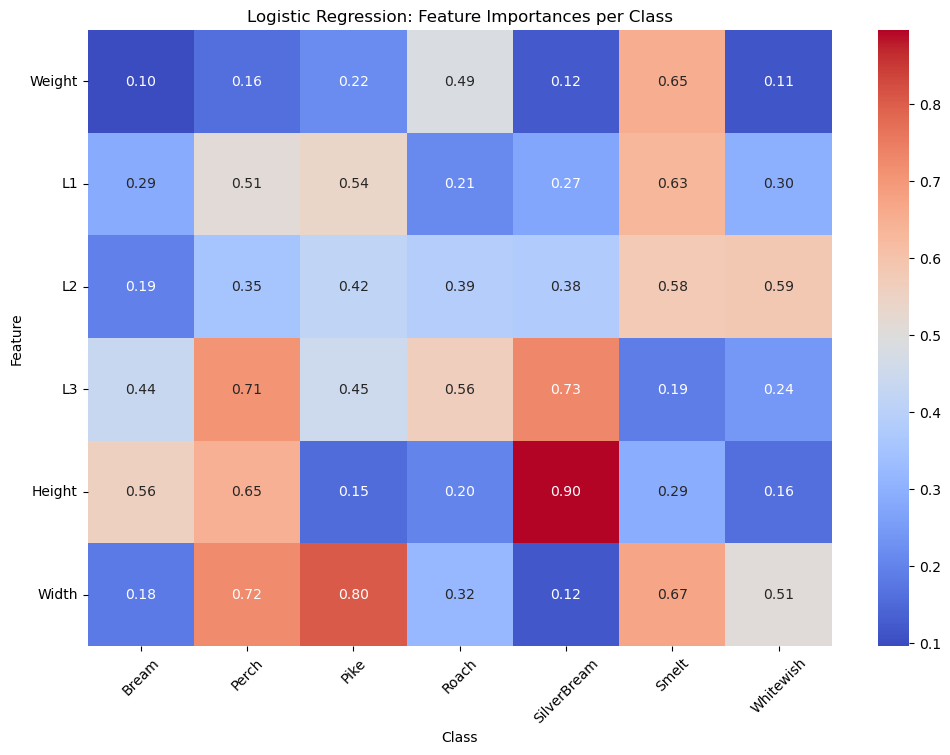

In [319]:
def plot_logistic_regression_feature_importances(results_list, feature_names, class_names):
    """
    Aggregates class feature importances and plots them for logistic regression.

    Parameters:
    - results_list: List of dictionaries containing results from multiple runs.
    - feature_names: List of feature names.

    Returns:
    - None
    """
    # Aggregating class feature importances for Logistic Regression
    class_feature_importances = []

    for result in results_list:
        if "Logistic Regression" in result:
            class_feature_importances.extend(result["Logistic Regression"]["class_features"])

    # Stacking all coefficients to find max absolute value for normalization

    stacked_coefs = np.vstack(class_feature_importances)
    
    # Calculate the maximum absolute coefficient for each feature
    max_abs_coefs = np.max(np.abs(stacked_coefs), axis=0)

    # Normalize the coefficients by the maximum absolute value for each feature
    normalized_importances = []
    for coefs in class_feature_importances:
        normalized_coefs = np.abs(coefs) / max_abs_coefs
        normalized_importances.append(normalized_coefs)

    # Averaging the normalized coefficients
    averaged_importances = np.mean(np.stack(normalized_importances), axis=0)

    # Creating a DataFrame for easier plotting
    data = []
    for class_idx, feature_coefs in enumerate(averaged_importances):
        for feature_idx, coef in enumerate(feature_coefs):
            data.append({
                'Class': class_names[class_idx],
                'Feature': feature_names[feature_idx],
                'Importance': coef
            })

    df = pd.DataFrame(data)

    # Plotting the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Feature', y='Importance', hue='Class', data=df)
    plt.title('Logistic Regression: Feature Importances per Class')
    plt.xticks(rotation=45)
    plt.legend(title='Class')
    plt.show()
    
    
def plot_logistic_regression_feature_importances2(results_list, feature_names, class_names):
    """
    Aggregates class feature importances and plots them as a heatmap for logistic regression.

    Parameters:
    - results_list: List of dictionaries containing results from multiple runs.
    - feature_names: List of feature names.
    - class_names: List of class names.

    Returns:
    - None
    """
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Aggregating class feature importances for Logistic Regression
    class_feature_importances = []

    for result in results_list:
        if "Logistic Regression" in result:
            class_feature_importances.extend(result["Logistic Regression"]["class_features"])

    # Stacking all coefficients to find max absolute value for normalization
    stacked_coefs = np.vstack(class_feature_importances)
    
    # Calculate the maximum absolute coefficient for each feature
    max_abs_coefs = np.max(np.abs(stacked_coefs), axis=0)

    # Normalize the coefficients by the maximum absolute value for each feature
    normalized_importances = []
    for coefs in class_feature_importances:
        normalized_coefs = np.abs(coefs) / max_abs_coefs
        normalized_importances.append(normalized_coefs)

    # Averaging the normalized coefficients
    averaged_importances = np.mean(np.stack(normalized_importances), axis=0)

    # Creating a DataFrame for easier plotting
    data = np.zeros((len(feature_names), len(class_names)))
    for class_idx, feature_coefs in enumerate(averaged_importances):
        for feature_idx, coef in enumerate(feature_coefs):
            data[feature_idx, class_idx] = coef

    df = pd.DataFrame(data, columns=class_names, index=feature_names)

    # Plotting the feature importances as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Logistic Regression: Feature Importances per Class')
    plt.xlabel('Class')
    plt.ylabel('Feature')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    
plot_logistic_regression_feature_importances2(all_runs_class_features, X_train.columns, sorted(set(y.unique())))

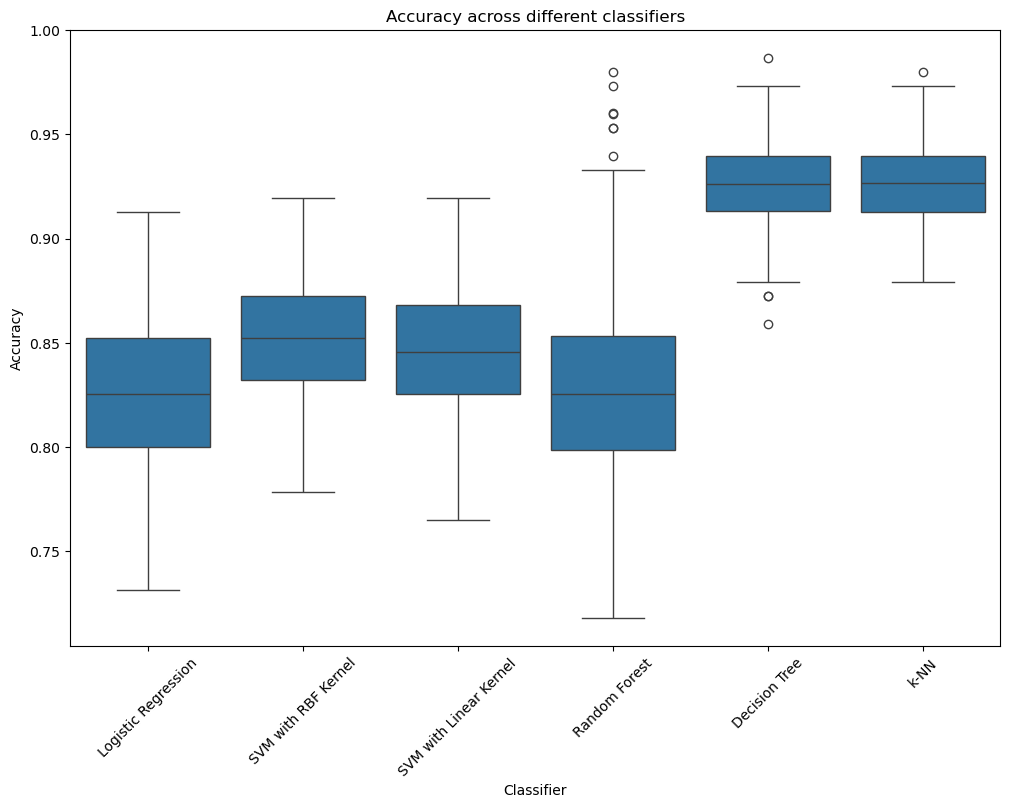

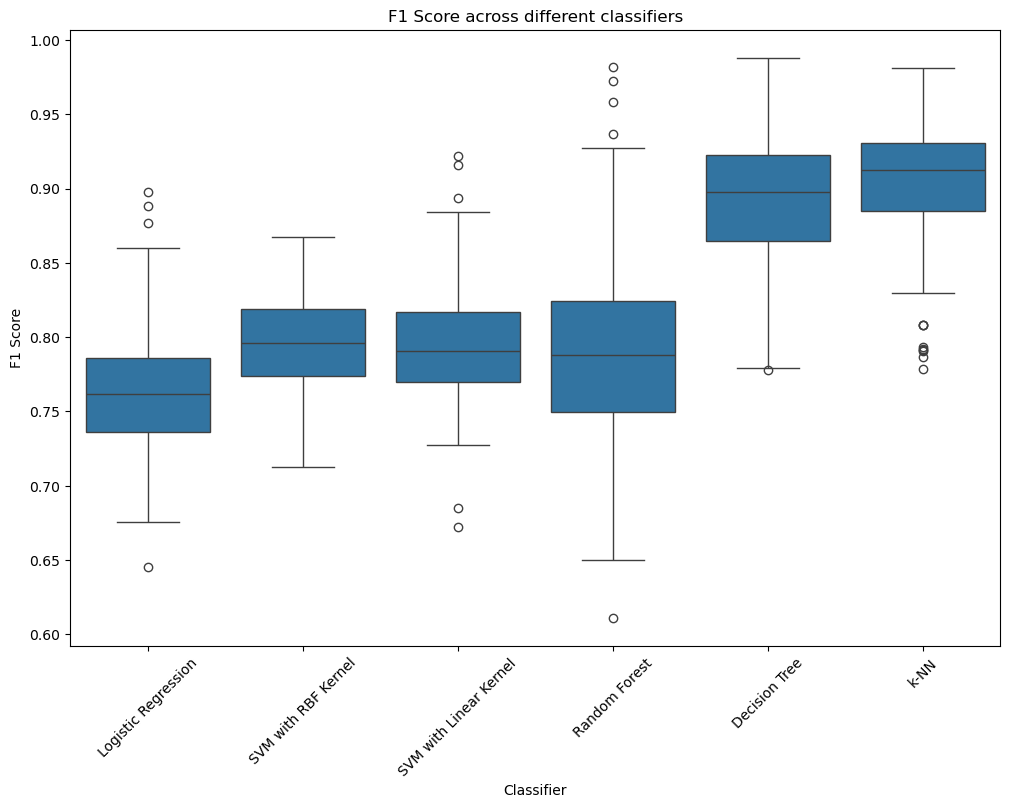

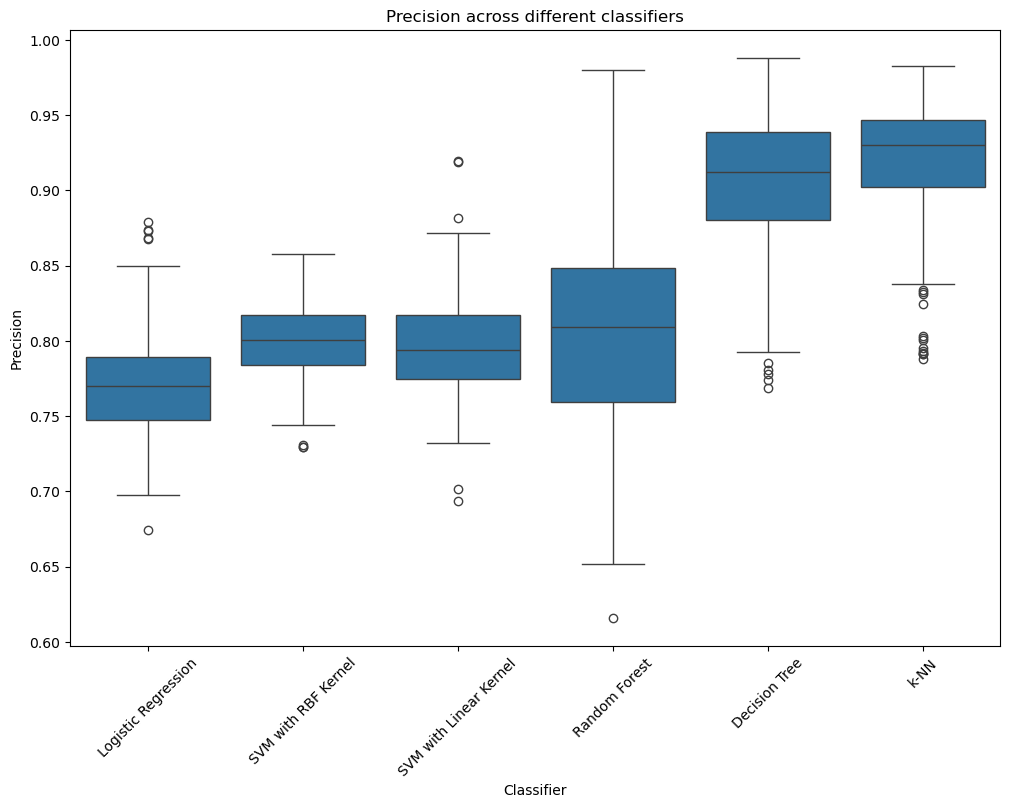

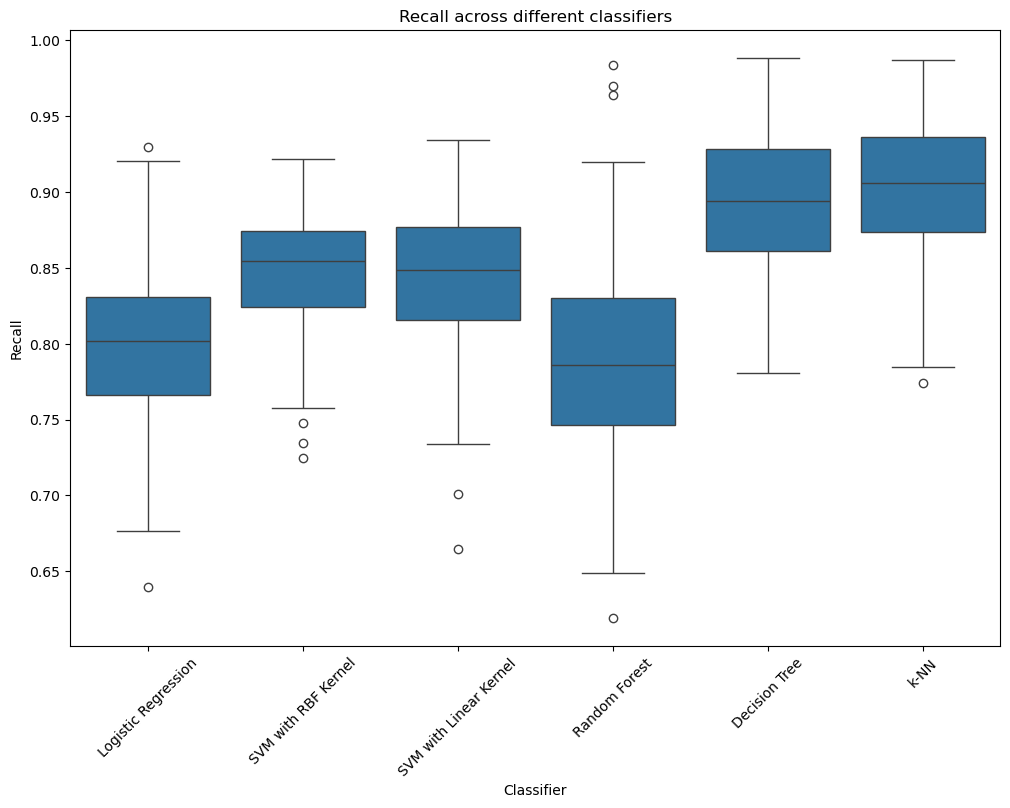

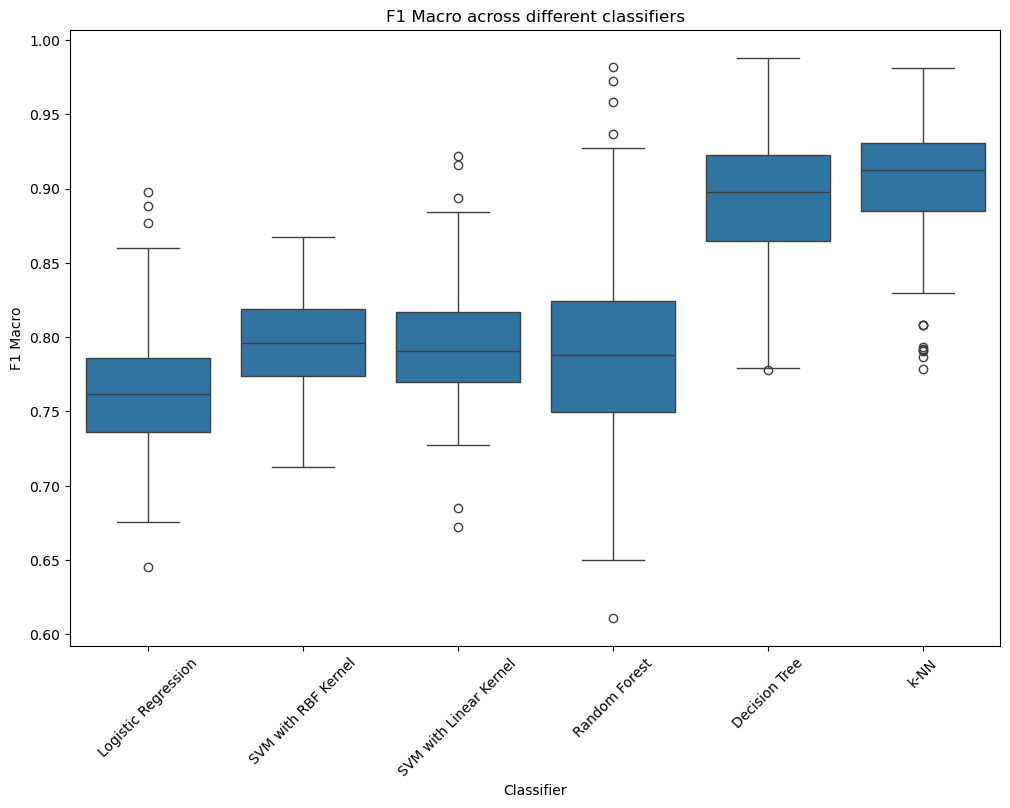

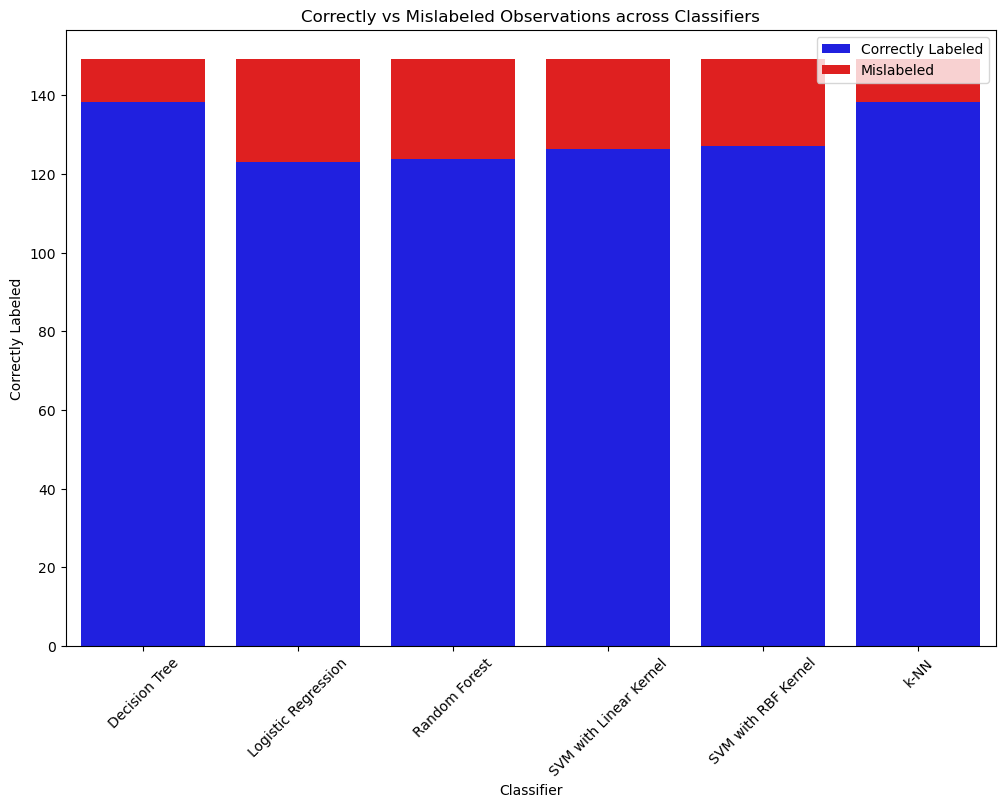

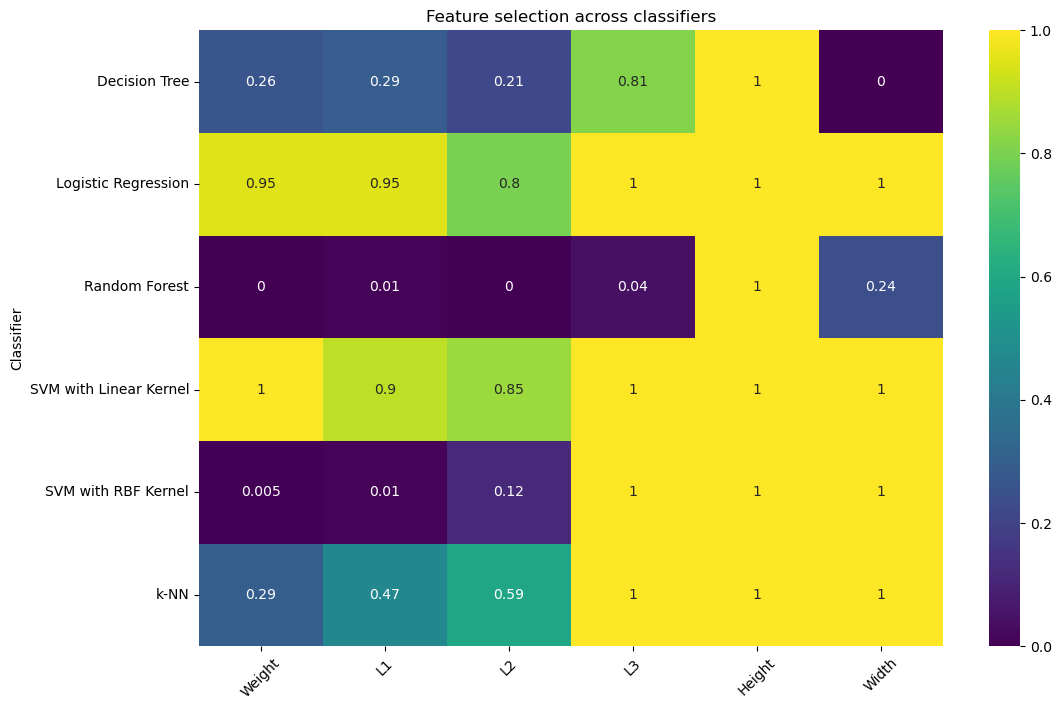

In [304]:
def aggregate_and_plot_results(results_list):
    """
    Aggregates results from multiple runs and plots the metrics.

    Parameters:
    - results_list: List of dictionaries containing results from multiple runs.

    Returns:
    - None
    """
    # Aggregating the results
    aggregated_results = {}
    for result in results_list:
        for clf, metrics in result.items():
            if clf not in aggregated_results:
                aggregated_results[clf] = {
                    'accuracy': [],
                    'precision': [],
                    'recall': [],
                    'f1_score': [],
                    'f1_macro': [],
                    'selected_features': [],
                    'correctly_labeled': [],
                    'mislabeled': []
                }
            aggregated_results[clf]['accuracy'].extend(metrics['accuracy'])
            aggregated_results[clf]['precision'].extend([np.mean(p) for p in metrics['precision']])
            aggregated_results[clf]['recall'].extend([np.mean(r) for r in metrics['recall']])
            aggregated_results[clf]['f1_score'].extend([np.mean(f) for f in metrics['f1_score']])
            aggregated_results[clf]['f1_macro'].extend(metrics['f1_macro'])
            aggregated_results[clf]['selected_features'].extend(metrics['selected_features'])
            aggregated_results[clf]['correctly_labeled'].extend(metrics['correctly_labeled'])
            aggregated_results[clf]['mislabeled'].extend(metrics['mislabeled'])

    # Converting to DataFrame for easier plotting
    data = []
    for clf, metrics in aggregated_results.items():
        for i in range(len(metrics['accuracy'])):
            data.append({
                'Classifier': clf,
                'Accuracy': metrics['accuracy'][i],
                'Precision': metrics['precision'][i],
                'Recall': metrics['recall'][i],
                'F1 Score': metrics['f1_score'][i],
                'F1 Macro': metrics['f1_macro'][i],
                'Correctly Labeled': metrics['correctly_labeled'][i],
                'Mislabeled': metrics['mislabeled'][i]
            })

    df = pd.DataFrame(data)

    # Plotting metrics
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Classifier', y='Accuracy', data=df)
    plt.title('Accuracy across different classifiers')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Classifier', y='F1 Score', data=df)
    plt.title('F1 Score across different classifiers')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Classifier', y='Precision', data=df)
    plt.title('Precision across different classifiers')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Classifier', y='Recall', data=df)
    plt.title('Recall across different classifiers')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Classifier', y='F1 Macro', data=df)
    plt.title('F1 Macro across different classifiers')
    plt.xticks(rotation=45)
    plt.show()

    # Summarize correctly and mislabeled counts
    labeling_data = df.groupby('Classifier').agg({
        'Correctly Labeled': 'mean',
        'Mislabeled': 'mean'
    }).reset_index()

    # Plotting correctly vs mislabeled observations
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Classifier', y='Correctly Labeled', data=labeling_data, color='b', label='Correctly Labeled')
    sns.barplot(x='Classifier', y='Mislabeled', data=labeling_data, color='r', label='Mislabeled', bottom=labeling_data['Correctly Labeled'])
    plt.title('Correctly vs Mislabeled Observations across Classifiers')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # Visualizing feature selection
    feature_names = X_train.columns
    selected_features_data = []
    for clf, metrics in aggregated_results.items():
        for features in metrics['selected_features']:
            selected_features_data.append({
                'Classifier': clf,
                **{feature_names[i]: features[i] for i in range(len(features))}
            })

    selected_features_df = pd.DataFrame(selected_features_data)

    # Plotting heatmap of selected features
    plt.figure(figsize=(12, 8))
    sns.heatmap(selected_features_df.groupby('Classifier').mean(), annot=True, cmap='viridis')
    plt.title('Feature selection across classifiers')
    plt.xticks(rotation=45)
    plt.show()
    

aggregate_and_plot_results(all_runs)

## c)
